In [2]:

from DescritoresDeImagem.readwritendarray import extractimagesdescriptor, readfilendarray
from DescritoresDeImagem.utils import lpq_function

# Standart Scale, SVC and KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from scipy.stats import loguniform

import numpy as np
import pickle


In [3]:
#GLCM

distances=[1,2,4,8,16,32,64,128,256]
angles=np.deg2rad([0,45,90,180,270])


#LBP
Winsize=25

decorr=1

CVPARTS=5 # number of CV parts
RUN=True

if RUN:
    function_glcm=extractimagesdescriptor("DadosExtraidos/Y_Resultado.txt","DadosExtraidos/X_GLCM.txt","BasedeDados/*.bmp","GLCM",)
    function_glcm(angles=angles,distances=distances)

    function_lbp=extractimagesdescriptor(file="DadosExtraidos/Y_Resultado.txt",filename="DadosExtraidos/X_LBP.txt",pathimg="BasedeDados/*.bmp",descriptor="LBP")
    function_lbp(winSize=Winsize,decorr=decorr)



X_lbp=readfilendarray(filename="DadosExtraidos/X_LBP.txt")

X_lpq=lpq_function("BasedeDados/*.bmp",P=25,R=6)

X_glcm=readfilendarray(filename="DadosExtraidos/X_GLCM.txt")

y=readfilendarray(filename="DadosExtraidos/Y_Resultado.txt",data="s")

y = y.reshape(-1, 1)

x_lpq_lpq_glcm=np.concatenate((X_lbp,X_lpq,X_glcm,y),axis=1)

knn_x_lpq_lpq_glcm=np.concatenate((X_lbp,X_lpq,y),axis=1)

X_train_model,X_test_model=train_test_split(x_lpq_lpq_glcm,test_size=0.2,train_size=0.8,random_state=999)

X_train_knn_model,X_test_knn_model=train_test_split(knn_x_lpq_lpq_glcm,test_size=0.2,train_size=0.8,random_state=999)

FUNCTION GLCM
FUNCTION LBP


In [4]:
y_train=X_train_model[:,-1]
y_test=X_test_model[:,-1]


y_test_knn=X_test_knn_model[:,-1]
y_train_knn=X_train_knn_model[:,-1]


X_train_model=X_train_model[:,:-1]
X_test_model=X_test_model[:,:-1]


X_test_knn_model=X_test_knn_model[:,:-1]
X_train_knn_model=X_test_knn_model[:,:-1]

In [5]:
def randomgridsearchotimizator(n_iter:int,scoring:str,cvparts,pipe,parameters):
    return RandomizedSearchCV(estimator=pipe,param_distributions=parameters,n_iter=n_iter,scoring=scoring,cv=cvparts,n_jobs=6,error_score='raise')

In [6]:
pipe=Pipeline(steps=[("scalar",StandardScaler()),
                     ('pca', PCA()),
                     ("model",SVC())])


parameters = {
    "pca__n_components":[16,32,64,128],
    "pca__svd_solver":['auto', 'full', 'arpack', 'randomized'],
    "model__coef0": [0,1,2,3,4,5],
    "model__degree": [1,2,3,4,5],
    "model__kernel": ['poly',"rbf","sigmoid"],
    "model__C": loguniform(1e-2, 1e1),
    "model__gamma": ["scale", "auto"],
    "model__tol": loguniform(1e-3, 1e-1),
}



In [7]:
NOTOPTPARAMATERS=False

if NOTOPTPARAMATERS:
    svmlbp_lpq=pickle.load("./Models/svm_LBP_LPQ_GLCM.pkl")
else:
    svmlbp_lpq=randomgridsearchotimizator(parameters=parameters,pipe=pipe,scoring="f1_macro",cvparts=5,n_iter=15)

In [8]:
svmlbp_lpq.fit(X=X_train_model,y=y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                             ('pca', PCA()),
                                             ('model', SVC())]),
                   n_iter=15, n_jobs=6,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x72a08c67b7f0>,
                                        'model__coef0': [0, 1, 2, 3, 4, 5],
                                        'model__degree': [1, 2, 3, 4, 5],
                                        'model__gamma': ['scale', 'auto'],
                                        'model__kernel': ['poly', 'rbf',
                                                          'sigmoid'],
                                        'model__tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x72a08c67a0b0>,
                                        'pca__n_components': [16, 32, 64, 128],
                                        'pca__svd_solver': ['auto', 'full',
                                                            'arpack',
                                                            'randomized']},
                   scoring='f1_macro')

In [9]:
print(svmlbp_lpq.best_score_)
print(svmlbp_lpq.best_params_)


0.7337011178065912
{'model__C': np.float64(0.24367935778829913), 'model__coef0': 4, 'model__degree': 4, 'model__gamma': 'auto', 'model__kernel': 'poly', 'model__tol': np.float64(0.009947476371975354), 'pca__n_components': 128, 'pca__svd_solver': 'arpack'}


In [10]:
ypredsvmglcm=svmlbp_lpq.predict(X=X_test_model)

In [11]:
print("\tSVM (LBP+LPQ+GLCM) \n")
print(classification_report(y_test,y_pred=ypredsvmglcm)+"\n")

	SVM (LBP+LPQ+GLCM) 

              precision    recall  f1-score   support

           a       0.76      0.79      0.78        73
          ad       0.86      0.85      0.85        66
           d       0.59      0.81      0.68        64
           f       0.79      0.71      0.75        76
           j       0.65      0.62      0.63        74
          jd       0.74      0.64      0.69        76
          jt       0.77      0.74      0.75        66
           m       0.77      0.71      0.74        72
          md       0.84      0.68      0.75        72
           n       0.87      0.82      0.84        87
           o       0.60      0.69      0.64        51
           s       0.63      0.78      0.70        63

    accuracy                           0.74       840
   macro avg       0.74      0.74      0.73       840
weighted avg       0.75      0.74      0.74       840




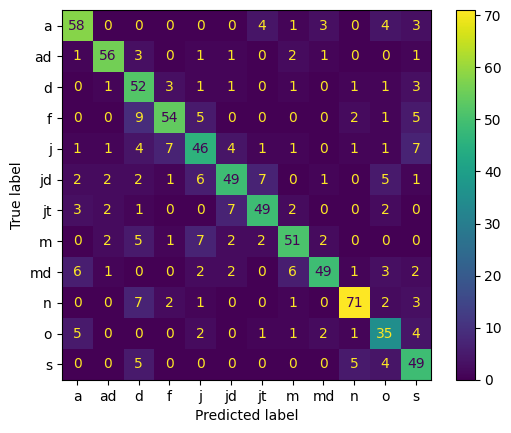

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred=ypredsvmglcm)

In [ ]:
pipe=Pipeline(steps=[("scalar",StandardScaler()),
                     ('pca', PCA()),
                     ("knn",KNeighborsClassifier())]) 
parameters = {
    "pca__n_components":[16,32,64,128],
    "pca__svd_solver":['auto', 'full', 'arpack', 'randomized'],
    "knn__n_neighbors": [1,2,3,5,7,10,15,20,25,30,50,100,500,1000],  
    "knn__weights": ['uniform', 'distance'],
    "knn__metric": ['euclidean', 'manhattan','chebyshev'], 
    "knn__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "knn__leaf_size": [10, 20, 30, 50,60,70,80,85,89,90,100,1000],  
    "knn__p": [1, 2]  
}



In [14]:

NOTOPTPARAMATERS=False

if NOTOPTPARAMATERS:
   knn_lbp_lqb_glcm=svmlbp_lpq=pickle.load("./Models/knn_LBP_LPQ_GLCM.pkl")
else:
    knn_lbp_lqb_glcm=randomgridsearchotimizator(parameters=parameters,pipe=pipe,scoring="f1_macro",cvparts=CVPARTS,n_iter=25)

In [15]:
labelencoder=LabelEncoder()

ln_y=labelencoder.fit_transform(y_train_knn)

In [16]:
knn_lbp_lqb_glcm.fit(X=X_train_model,y=ln_y)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                             ('pca', PCA()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=25, n_jobs=6,
                   param_distributions={'knn__algorithm': ['auto', 'ball_tree',
                                                           'kd_tree', 'brute'],
                                        'knn__leaf_size': [10, 20, 30, 50, 60,
                                                           70, 80, 85, 89, 90,
                                                           100, 1000],
                                        'knn__metric': ['euclidean',
                                                        'manhattan',
                                                        'chebyshev'],
                                        'knn__n_neighbors': [1, 2, 3, 5, 7, 10,
                                                             15, 20, 25, 30, 50,
                                                             100, 500, 1000],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform', 'distance'],
                                        'pca__n_components': [16, 32, 64, 128],
                                        'pca__svd_solver': ['auto', 'full',
                                                            'arpack',
                                                            'randomized']},
                   scoring='f1_macro')

In [17]:

ln_y_test=labelencoder.fit_transform(y_test)

print(knn_lbp_lqb_glcm.best_params_)
print(knn_lbp_lqb_glcm.best_score_)

{'pca__svd_solver': 'full', 'pca__n_components': 32, 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 25, 'knn__metric': 'manhattan', 'knn__leaf_size': 60, 'knn__algorithm': 'kd_tree'}
0.5364129230763806


In [18]:
ypredknnglcm=knn_lbp_lqb_glcm.predict(X=X_test_model)

In [19]:
print("\tKNN(LBP+LPQ+GLCM) \n")
print(classification_report(y_true=ln_y_test,y_pred=ypredknnglcm)+"\n")

	KNN(LBP+LPQ+GLCM) 

              precision    recall  f1-score   support

           0       0.65      0.42      0.51        73
           1       0.67      0.70      0.68        66
           2       0.31      0.61      0.41        64
           3       0.55      0.34      0.42        76
           4       0.50      0.54      0.52        74
           5       0.62      0.42      0.50        76
           6       0.57      0.55      0.56        66
           7       0.83      0.60      0.69        72
           8       0.75      0.38      0.50        72
           9       0.70      0.64      0.67        87
          10       0.37      0.61      0.46        51
          11       0.38      0.63      0.48        63

    accuracy                           0.53       840
   macro avg       0.57      0.54      0.53       840
weighted avg       0.59      0.53      0.54       840




In [20]:

with open(f"Models/svm_LBP_LPQ_GLCM.pkl",mode="wb") as fsvm:
    pickle.dump(svmlbp_lpq,fsvm)

with open("Models/knn_LBP_LPQ_GLCM.pkl",mode="wb") as fknn:
    pickle.dump(knn_lbp_lqb_glcm,fknn)